In [1]:
import numpy as np
import pandas as pd
from numbers import Number
from typing import List, Union
from node import Node
from collections import Counter, namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from dt_visualizer import DecisionTreeVisualizer
import matplotlib.pyplot as plt
import graphviz as gpz

In [2]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth:int=10, 
                 min_samples_split:int=2, 
                 num_features:int=None,
                 coef_var_threshold = 1,
                 impurity_measure:str="var"):
        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.num_features = num_features
        self.coef_var_threshold = coef_var_threshold
        
        self.impurity_measure = {"var": np.var, 
                                 "std": np.std}[impurity_measure]
        self.root = None
        
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        
        X = X.values
        y = y.values
        
        if (self.num_features is None) or (self.num_features > X.shape[1]):
            self.num_features = X.shape[1]
            
        self.root = self._grow_tree(X, y)
        
    
    def predict(self, X:np.ndarray):
        X = X.values
        
        predictions = []
        
        for x in X:
            x_pred = self._traverse_tree(x, self.root)
            predictions.append(x_pred)
            
        return np.array(predictions)
        
        
    def _grow_tree(self, X:np.ndarray, y:np.ndarray, depth:int=0):
        samples_num, features_num = X.shape
        num_labels = np.unique(y).shape[0]
        
        if (depth>=self.max_depth) or (samples_num<=self.min_samples_split):
            return Node( leaf_value=np.mean(y) )
        
        features_indices = np.random.choice(features_num, self.num_features, replace=False)
        
        best_feature_idx, best_threshold = self._best_split(X, y, features_indices)
        left_indices, right_indices = self._split(X[:, best_feature_idx], best_threshold)
        
        left = self._grow_tree(X[left_indices], y[left_indices], depth=depth+1)
        right = self._grow_tree(X[right_indices], y[right_indices], depth=depth+1)
        
        if (left is None) and (right is None):
            return
        
        return Node(feature_idx=best_feature_idx, 
                    threshold=best_threshold, 
                    left=left, 
                    right=right)
        
    
    def _best_split(self, X:np.ndarray, y:np.ndarray, features_indices:np.ndarray):
        best_info_gain = -1
        best_feature_idx = None
        best_threshold = None
            
        for i in features_indices:
            feature_column = X[:, i]
            feature_threshold = np.mean(feature_column)

            threshold_info_gain = self._info_gain(y, feature_column, feature_threshold)
            if threshold_info_gain > best_info_gain:
                best_info_gain = threshold_info_gain
                best_feature_idx = i
                best_threshold = feature_threshold
                    
        return best_feature_idx, best_threshold
    
    
    def _info_gain(self, y:np.ndarray, feature_column:np.ndarray, threshold:Number):
        parent_impurity = self.impurity_measure(y)
        
        left_indices, right_indices = self._split(feature_column, threshold)
        children_impurity = 0
        
        if ( len(left_indices) == 0 ) or ( len(right_indices) == 0 ):
            return 0
        
        for idx in [left_indices, right_indices]:
            y_child = y[idx]
            
            weighted_child_impurity = None
            
            if len(y_child) <= 1:
                weighted_child_impurity = 0
            else:
                weighted_child_impurity = (y_child.shape[0] / y.shape[0]) * self.impurity_measure(y_child)
            
            children_impurity += weighted_child_impurity
            
        return parent_impurity - children_impurity
    
    
    def _split(self, feature_column:np.ndarray, threshold:Number):
        condition = (feature_column <= threshold)
        left_indices = np.asarray(condition).nonzero()
        right_indices = np.asarray(~condition).nonzero()
        return left_indices, right_indices
        
        
    def _entropy(self, y:np.ndarray):
        classes_probs = np.bincount(y) / y.shape[0]
        p_log_p = -classes_probs * np.log2(classes_probs)
        return np.sum(p_log_p)
    
    
    def _gini(self, y:np.ndarray):
        classes_probs = np.bincount(y) / y.shape[0]
        probs_squares_sum = np.square(classes_probs)
        return 1 - np.sum(probs_squares_sum)
    
    
    def _traverse_tree(self, x:np.ndarray, node:Node):
        if node.is_leaf_node():
            return node.leaf_value
        
        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [3]:
from sklearn.datasets import load_diabetes

In [4]:
X, y = load_diabetes(return_X_y=True, as_frame=True)

In [5]:
y_vals = y.values
np.mean(y_vals)/np.var(y_vals) 

0.025655385695962034

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1234)

In [7]:
dt = CustomDecisionTreeRegressor(min_samples_split=4, max_depth=10)

In [8]:
dt.fit(X_train, y_train)

In [9]:
pred = dt.predict(X_test)

In [10]:
mean_squared_error(y_test, pred)

5163.844335205993

In [11]:
dt_visualizer = DecisionTreeVisualizer(dt.root, X.columns)

In [12]:
graph = dt_visualizer.visualize_tree()

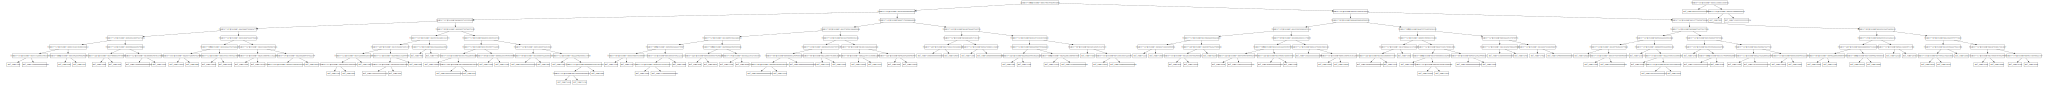

In [13]:
graph

In [14]:
dt_visualizer.graph.render(filename="reg", 
                           directory='imgs', 
                           format='png', view=True).replace('\\', '/')

'imgs/reg.png'

---

In [15]:
dt_reg = DecisionTreeRegressor(min_samples_split=4, max_depth=10)

In [16]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_split=4)

In [17]:
predsk_reg = dt_reg.predict(X_test)

In [18]:
mean_squared_error(y_test, predsk_reg)

5443.509369774975

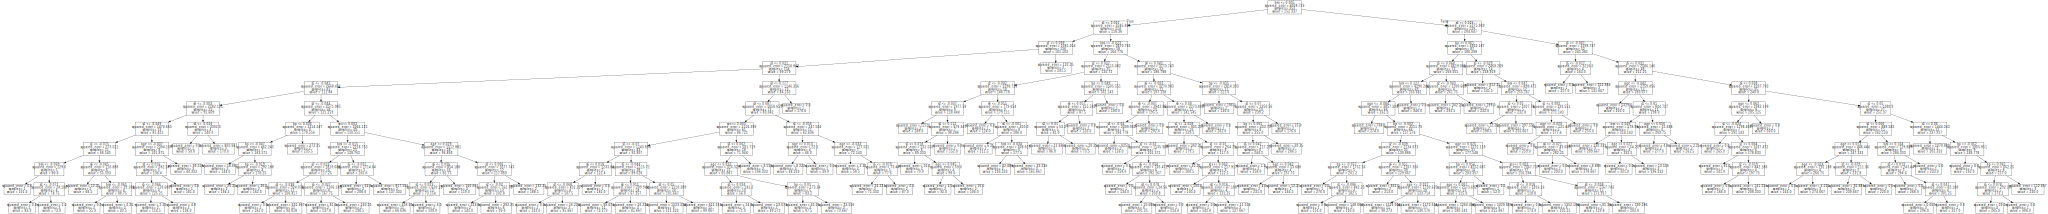

In [19]:
dot = export_graphviz(dt_reg, feature_names=X.columns)
png = gpz.Source(dot, format='png')
png